In [1]:
from IPython.core.display import HTML, display
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# MATH 046 Final Project

<a href="https://greydanus.github.io/fractal_tree/index.html"><img src="website.png" alt="Fractal tree website" style="width: 400px;"/></a>
This notebook analyzes the fractal tree simulation hosted at https://greydanus.github.io/fractal_tree/index.html.

We reconstruct the simulation in python and plot positions, velocities, and phase space behavior of nodes at different locations in the tree

## Helper objects

### Vector object

This is not the most efficient way of vectorizing operations, but it parallels the JavaScript simulation, allowing us to get closure on numerical errors

In [2]:
# A 2D vector utility
class Vec():
    def __init__(self, v):
        v = np.array(v)
        self.v = v.astype(float)
    def dist_from(self, w):
        return np.sqrt(np.sum(np.power(self.v-w.v,2)))
    def length(self):
        return np.sqrt(np.sum(np.power(self.v,2)))
    def add(self, w):
        return Vec(self.v + w.v)
    def sub(self, w):
        return Vec(self.v - w.v)
        return cp
    def rotate(self, a):
        x = self.v[0]*math.cos(a) + self.v[1]*math.sin(a)
        y = -self.v[0]*math.sin(a) + self.v[1]*math.cos(a)
        return Vec(np.array([x,y]))
    def copy(self):
        return Vec(np.array([self.v[0],self.v[1]]))
    def scale(self, s):
        self.v = self.v * s
    def normalize(self):
        d = self.length()
        self.scale(1.0/d)

### Force object

In [3]:
class SinForce():
    def __init__(self, initial_force, wavelength):
        self.initial_force = initial_force
        self.temp = 0
        self.wavelength = wavelength
    def get_force(self, time):
        self.temp = self.initial_force.copy()
        self.temp.scale(math.sin(2*math.pi*time/self.wavelength))
        return self.temp;
    def new_magnitude(self, mag):
        if np.abs(mag) > 0:
            self.initial_force.normalize();
            self.initial_force.scale(mag)
    def new_wavelength(self, w):
        if w > 0:
            self.wavelength = w;
    def draw(self, time):
#         print "drew force"
        return

## Fractal Tree

The tree is built from three objects. The first object contains the root node, a rule for producing branches, and a list of node objects (branches) which in turn link to other node objects (more branches). The Frac object is our only external interface to the Fractal Tree object

### Fractal

Defines a base node with constants that determine the shape and dynamics of the fractal object

In [4]:
# An abstract fractal object
class Fractal():
    def __init__(self, world, depth):
        #properties
        self.isHead = True
        self.depth = depth
        self.rule = TreeRule(scale=0.6)
        self.rad = 30

        #translation dynamics
        self.m = math.pi*self.rad*self.rad
        self.tk = 50
        self.rk = .05
        self.tDamping = 0.03
        self.forceScale = 0.5

        self.p = Vec([world.v[0]/2, world.v[1] - self.rad])
        self.v = Vec([0,0])
        self.a = Vec([0,0])
        self.eqLength = 170

        #rotation dynamics
        self.theta = 0
        self.w = 0
        self.rDamping = 0
        self.eqChildThetas = []

        #world
        self.world = world
        self.data = {}
        self.data["x"] = np.zeros((0,2)); self.data["v"] = np.zeros((0,2))

        #nodes
        self.children = self.rule.getChildren(self)
        self.index = 0

        for child in self.children:
            connection = child.p.sub(self.p)
            self.eqChildThetas.append( math.atan2(connection.v[0], connection.v[1]) - self.theta )
    def draw(self):
#         print "draw top node"
        for child in self.children:
            child.draw();
    def tick(self, force):
#         print "tick top node"
        force.scale(self.forceScale)
        if len(self.children) > 0:
            for child in self.children:
                self.data = child.tick(force, self.data)

### Node

Defines the behavior of any given node in the tree. Each node contains information about its position, velocity, and its position relative to 1) its parent node and 2) its child nodes

In [5]:
# defines node-level behavior of fractal
class Node():
    def __init__(self, parent, index, p, reportData):
        #properties
        self.isHead = False;
        self.depth = parent.depth - 1;
        self.rule = parent.rule;
        self.rad = parent.rad * parent.rule.scale;

        #translational dynamics
        self.m = math.pi*self.rad*self.rad;
        self.tk = parent.tk * parent.rule.scale * parent.rule.scale;
        self.rk = parent.rk * parent.rule.scale;
        self.tDamping = parent.tDamping;

        self.p = p;
        self.v = parent.v.copy();
        self.a = parent.a.copy();
        self.eqLength = parent.eqLength*parent.rule.scale;

        #rotational dynamics
        self.theta = parent.theta;
        self.w = parent.w;
        self.rDamping = parent.rDamping;

        #world
        self.world = parent.world;
        self.reportData = reportData

        #nodes
        self.parent = parent;
        self.index = index
        self.children = self.rule.getChildren(self);

        connection = self.p.sub(self.parent.p);
        self.eqParentTheta = math.atan2(connection.v[0], connection.v[1]) - self.theta;
        self.eqChildThetas = [];
        for child in self.children:
            connection = child.p.sub(self.p)
            self.eqChildThetas.append( math.atan2(connection.v[0], connection.v[1]) - self.theta )
    def draw(self):
#         print "draw node "
        for child in self.children:
            child.draw();
    def tick(self, force, data):
        #calculate acceleration
        self.a.scale(0);
        alpha = 0;
        if len(self.children) > 0:
            for c, child in enumerate(self.children):
                #rotational part
                connection = child.p.sub(self.p)
                connectionTheta = math.atan2(connection.v[0], connection.v[1]) - self.theta
                dtheta = connectionTheta - self.eqChildThetas[c]
                if dtheta > math.pi:
                    dtheta = -1*math.pi + (dtheta - math.pi)
                dtheta = math.sin(dtheta)

                if np.abs(dtheta) > 0.00001:
                    child_alpha = self.eqLength*(self.rk*dtheta)*2/(self.m*self.rad*self.rad)

                    #translational ---> rotational
                    a_from_rotation = connection.rotate(-math.pi/2)
                    a_from_rotation.normalize()
                    a_from_rotation.scale( child.m*math.pow(child.rad,3)*child_alpha/(2*self.m*self.rad) )
                    self.a = self.a.add(a_from_rotation);

                #translational part
                x = self.p.sub(child.p).length() - self.eqLength;
                if np.abs(x) > 0.00001:
                    child_a = self.p.sub(child.p);
                    child_a.normalize();
                    child_a.scale(-1*self.tk*x/self.m);
                    self.a = self.a.add(child_a);
                    

        #acceleration from parent
        #rotational part
        connection = self.parent.p.sub(self.p);
        connectionTheta = math.atan2(connection.v[0], connection.v[1]) - self.theta;
        dtheta = connectionTheta - self.eqParentTheta;
        if dtheta > math.pi:
            dtheta = -1*math.pi + (dtheta - math.pi);
        dtheta = math.sin(dtheta);

        if np.abs(dtheta) > 0.00001:
            parent_alpha = self.parent.eqLength*(self.rk*dtheta)*2/(self.m*self.rad*self.rad);

            #translational ---> rotational
            a_from_rotation = connection.rotate(-math.pi/2);
            a_from_rotation.normalize();
            a_from_rotation.scale( self.parent.m*math.pow(self.parent.rad,3)*parent_alpha/(2*self.m*self.rad) );
            self.a = self.a.add(a_from_rotation);

        #translational part
        x = self.p.sub(self.parent.p).length() - self.parent.eqLength;
        if np.abs(x) > 0.00001:
            parent_a = self.p.sub(self.parent.p);
            parent_a.normalize();
            parent_a.scale(-1*self.tk*x/self.m);
            self.a = self.a.add(parent_a);

        #add wind to acceleration
        wind_a = force.copy();
        wind_a.scale(2*self.rad/self.m); # force goes with diameter for objects in 2D system
        self.a = self.a.add(wind_a);

        #update position, velocity
        self.v = self.v.add(self.a);
        self.v.v = self.v.v - self.v.v*self.tDamping;
        self.p = self.p.add(self.v);
#         if self.depth == 4:
#             print "position= " + str(self.p.v)
        
        if len(self.children) > 0:
            for child in self.children:
                newdata = child.tick(force, data)
        if self.reportData:
            data["x"] = np.concatenate((data["x"], np.reshape(self.p.v,(1,2))),axis=0)
            data["v"] = np.concatenate((data["v"], np.reshape(self.v.v,(1,2))),axis=0)
        return data

### TreeRule

Defines how to make new nodes which branch off of a parent node. The new nodes are scaled down by a scaling factor

In [6]:
class TreeRule():
    def __init__(self, scale=0.6):
        #properties
        self.scale = scale;
        self.branchAngles = [math.pi/6, -math.pi/6]; #angles of each of the branches
    def getChildren(self, parentNode):
        children = []
        if parentNode.depth > 0:
            if parentNode.isHead:
                p = parentNode.p.add(Vec([0,-1*parentNode.eqLength]))
                index = 0
                reportData = False
                children.append(Node(parentNode, index, p, reportData))
            else:
                for i, ba in enumerate(self.branchAngles):
                    vector = parentNode.p.sub(parentNode.parent.p)
                    vector.scale(self.scale)
                    vector = vector.rotate(ba)
                    p = parentNode.p.add(vector)
                    
                    index = i + parentNode.index
                    reportData = False
                    if False:
                        reportData = True
                    children.append(Node(parentNode, index, p, reportData))
        return children

## Inspecting Fractal Tree dynamics

### Collect data from simulation

First, build a tree with the same parameters used in the JavaScript simulation (https://greydanus.github.io/fractal_tree/index.html). We ran both simulations and obtained the same numerical results for 800 time steps (which is a good estimate of numerical closure).

Next, we run the simulation for 10 cycles. At each tier, we're saving the position and velocity information for the nodes in blue circles:
<img src="leftmost.png" alt="Central nodes" style="width: 200px;"/>

In [7]:
initial_wav = 800
initial_mag = .2
cwidth = 700
cheight = 500
iters = initial_wav*10
ntiers = 5
frac = Fractal(Vec([cwidth, cheight]), 5); force = SinForce(Vec([initial_mag,0]), initial_wav)

node = frac
for tier in range(1,ntiers+1):
    node=node.children[0]
    node.reportData = True
for i in range(iters):
    frac.tick(force.get_force(i))
    
tiers = [{}]
for tier in range(1,ntiers+1):
    tiers.append({});
    tiers[tier]["x"] = frac.data["x"][tier::ntiers]
    tiers[tier]["v"] = frac.data["v"][tier::ntiers]

### Plot position, velocity, and phase space

Given the data we've collected, make velocity, postition, and phase space plots for each of the leftmost nodes. Notice that for this set of parameters, the tree's motion is periodic

Tier 1


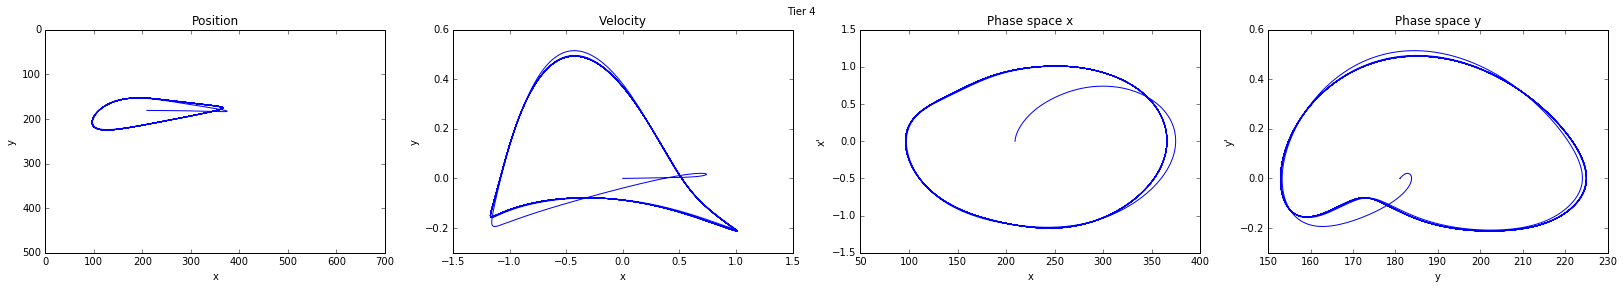

Tier 2


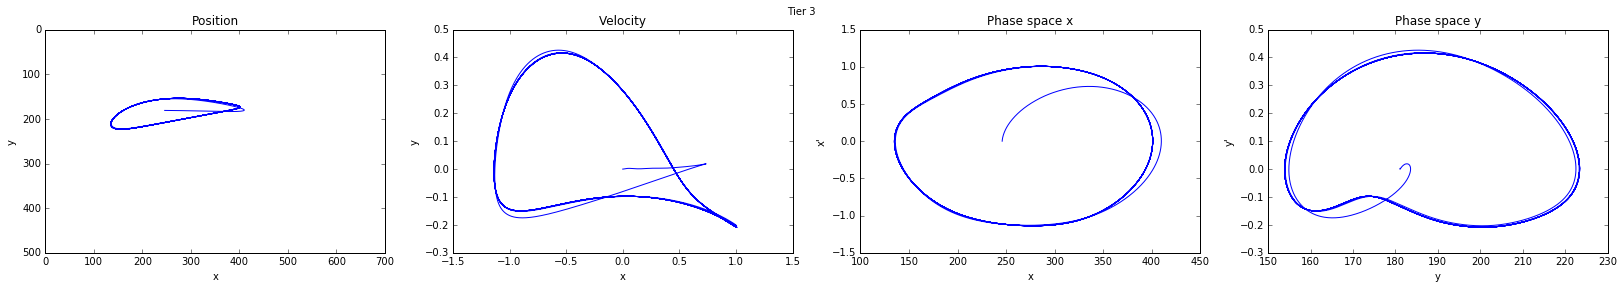

Tier 3


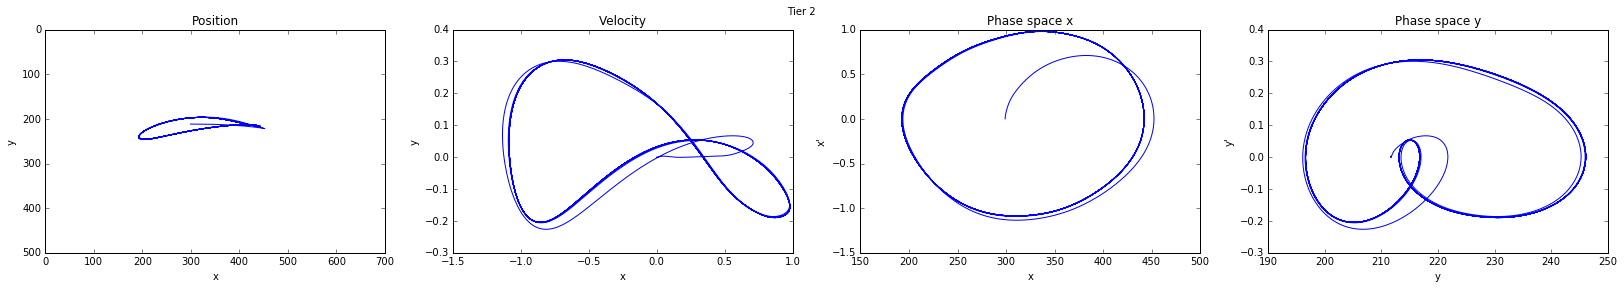

Tier 4


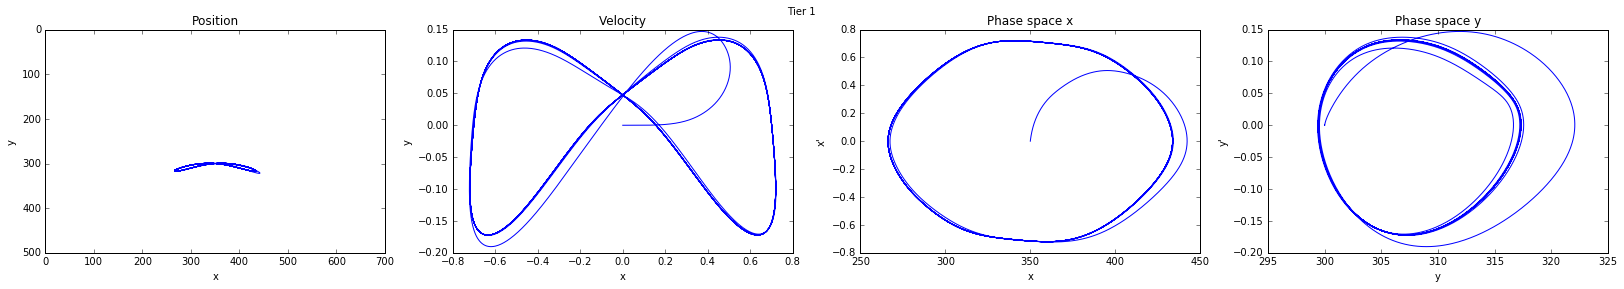

Tier 5


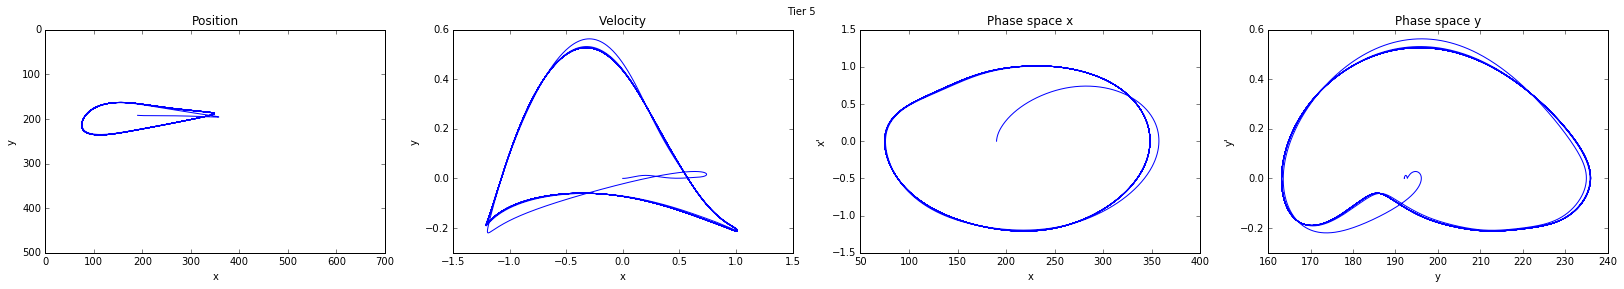

In [8]:
order = [4,3,2,1,5] #the order of the tiers is mixed up because data is collected during recursion
for tier in range(1,ntiers+1):
    print 'Tier ' + str(tier)
    x = tiers[tier]["x"]; v = tiers[tier]["v"];
    plt.figure(figsize=(28,4))
    
    plt.subplot(141) ; plt.title('Position'); plt.xlabel('x'); plt.ylabel('y')
    plt.axis([0.0,cwidth,0.0,cheight])
    plt.gca().invert_yaxis()
    plt.plot(x[:,0], x[:,1],'b-')
    
    plt.subplot(142) ; plt.title('Velocity'); plt.xlabel('x'); plt.ylabel('y')
    plt.plot(v[:,0], v[:,1],'b-')

    plt.subplot(143) ; plt.title('Phase space x'); plt.xlabel('x'); plt.ylabel('x\'')
    plt.plot(x[:,0], v[:,0],'b-')

    plt.subplot(144) ; plt.title('Phase space y'); plt.xlabel('y'); plt.ylabel('y\'')
    plt.plot(x[:,1], v[:,1],'b-')
    
    plt.suptitle('Tier ' + str(order[tier-1]))
    plt.savefig(str(order[tier-1])+'_leftmost_800.png')
    plt.show()

### Inspect nodes towards the middle of the tree

The motion differs for nodes towards the center of the tree. We're looking at the dynamics of the nodes in blue circles:
<img src="central.png" alt="Central nodes" style="width: 200px;"/>

In [9]:
initial_wav = 800
initial_mag = .2
cwidth = 700
cheight = 500
iters = initial_wav*10
ntiers = 5
frac = Fractal(Vec([cwidth, cheight]), 5); force = SinForce(Vec([initial_mag,0]), initial_wav)
frac.children[0].reportData = True
frac.children[0].children[1].reportData = True
frac.children[0].children[1].children[0].reportData = True
frac.children[0].children[1].children[0].children[0].reportData = True
frac.children[0].children[1].children[0].children[0].children[0].reportData = True

for i in range(iters):
    frac.tick(force.get_force(i))
    
tiers = [{}]
for tier in range(1,ntiers+1):
    tiers.append({});
    tiers[tier]["x"] = frac.data["x"][tier::ntiers]
    tiers[tier]["v"] = frac.data["v"][tier::ntiers]

Tier 1


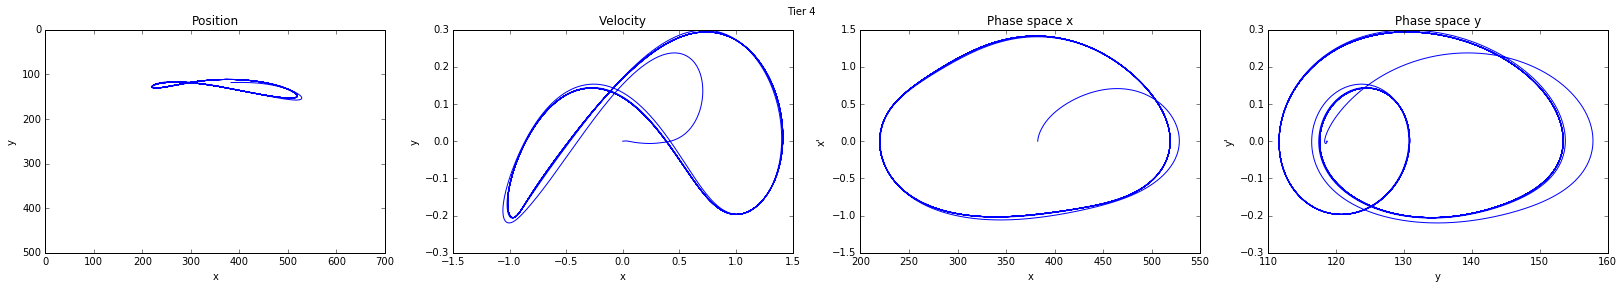

Tier 2


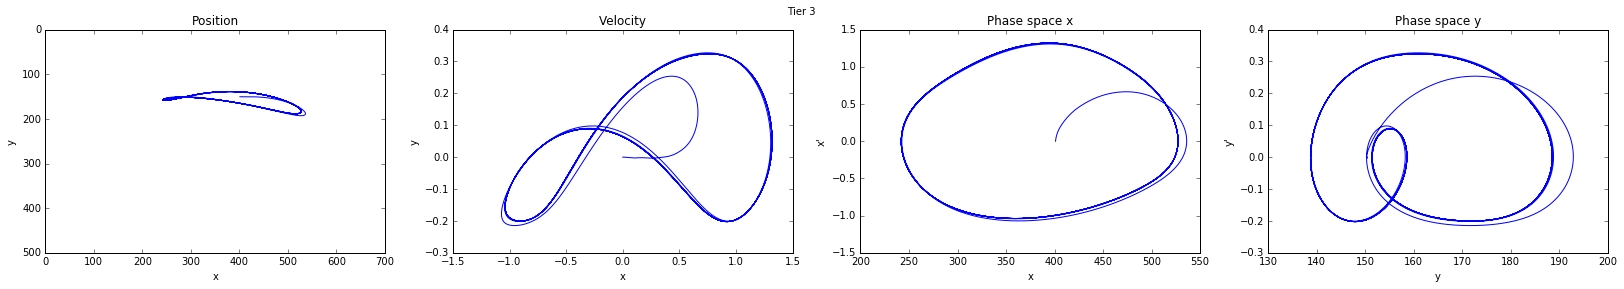

Tier 3


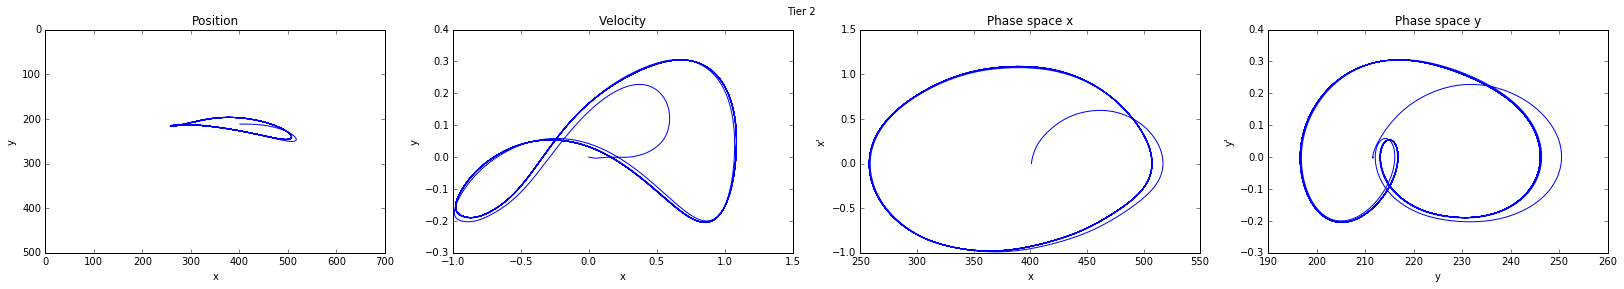

Tier 4


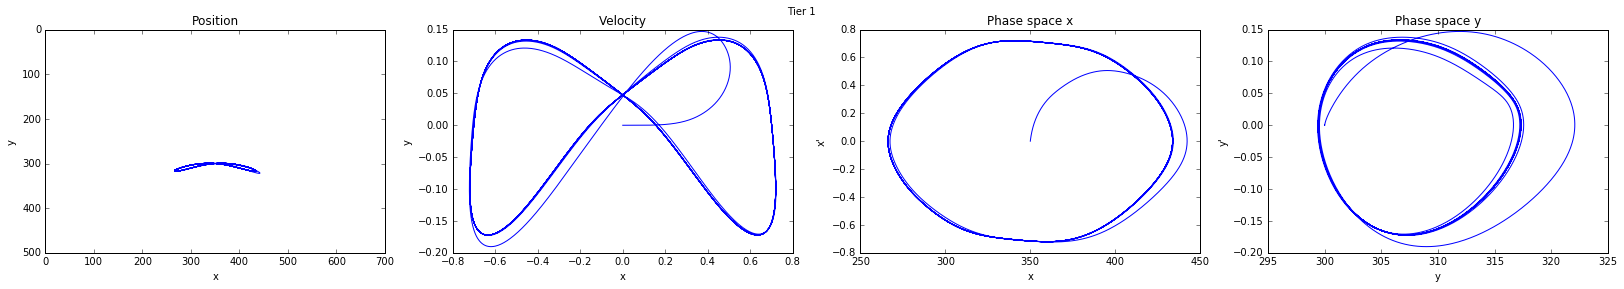

Tier 5


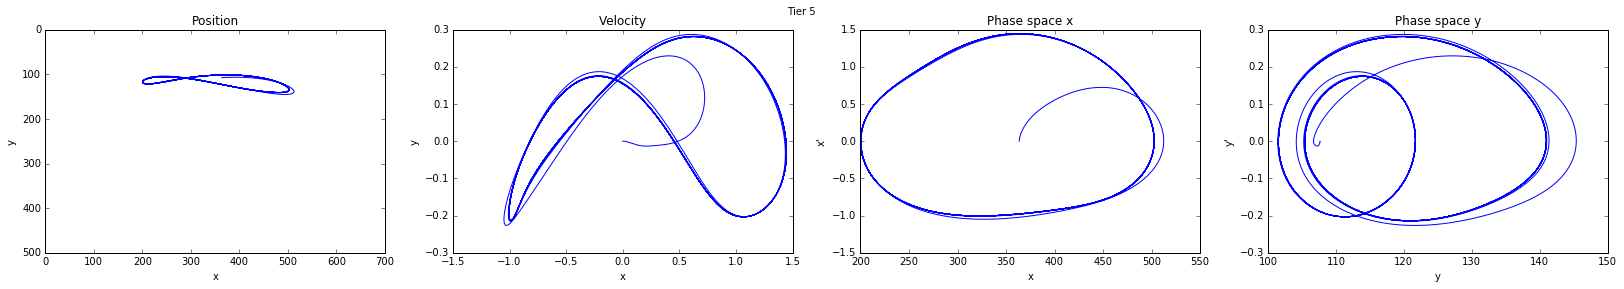

In [10]:
order = [4,3,2,1,5] #the order of the tiers is mixed up because data is collected during recursion
for tier in range(1,ntiers+1):
    print 'Tier ' + str(tier)
    x = tiers[tier]["x"]; v = tiers[tier]["v"];
    plt.figure(figsize=(28,4))
    
    plt.subplot(141) ; plt.title('Position'); plt.xlabel('x'); plt.ylabel('y')
    plt.axis([0.0,cwidth,0.0,cheight])
    plt.gca().invert_yaxis()
    plt.plot(x[:,0], x[:,1],'b-')
    
    plt.subplot(142) ; plt.title('Velocity'); plt.xlabel('x'); plt.ylabel('y')
    plt.plot(v[:,0], v[:,1],'b-')

    plt.subplot(143) ; plt.title('Phase space x'); plt.xlabel('x'); plt.ylabel('x\'')
    plt.plot(x[:,0], v[:,0],'b-')

    plt.subplot(144) ; plt.title('Phase space y'); plt.xlabel('y'); plt.ylabel('y\'')
    plt.plot(x[:,1], v[:,1],'b-')
    
    plt.suptitle('Tier ' + str(order[tier-1]))
    plt.savefig(str(order[tier-1])+'_center_800.png')
    plt.show()

### Test a different wavelength

Change the wavelength of the sinusoidal driving (wind) force. Again, we're we're saving the position and velocity information for the nodes in blue circles:
<img src="leftmost.png" alt="Central nodes" style="width: 200px;"/>
Notice that this simple change makes the system either chaotic or very slow to converge to a cycle

In [11]:
initial_wav = 300
initial_mag = .2
cwidth = 700
cheight = 500
iters = initial_wav*10
ntiers = 5
frac = Fractal(Vec([cwidth, cheight]), 5); force = SinForce(Vec([initial_mag,0]), initial_wav)

node = frac
for tier in range(1,ntiers+1):
    node=node.children[0]
    node.reportData = True
for i in range(iters):
    frac.tick(force.get_force(i))
    
tiers = [{}]
for tier in range(1,ntiers+1):
    tiers.append({});
    tiers[tier]["x"] = frac.data["x"][tier::ntiers]
    tiers[tier]["v"] = frac.data["v"][tier::ntiers]

Tier 1


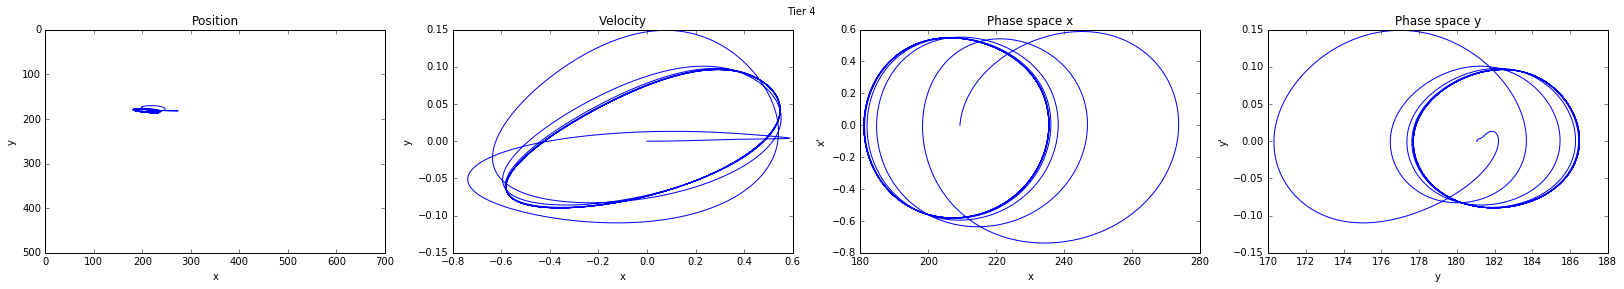

Tier 2


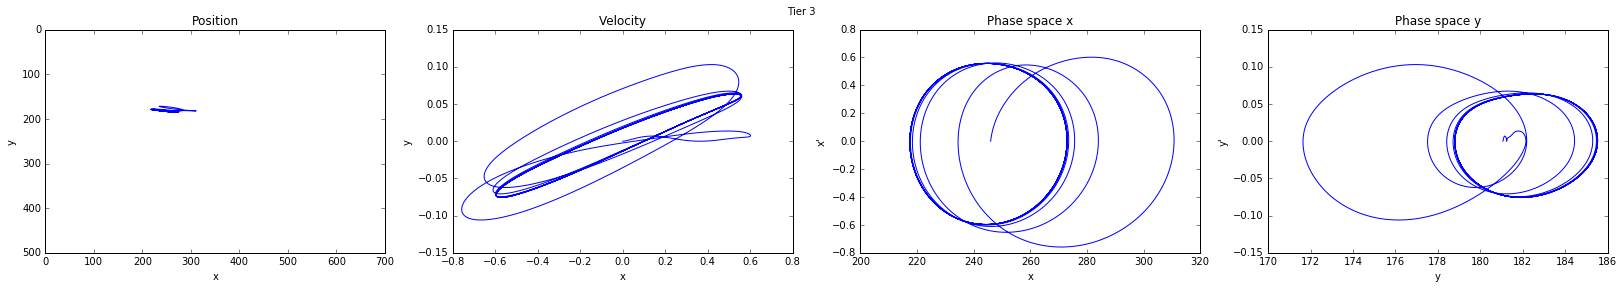

Tier 3


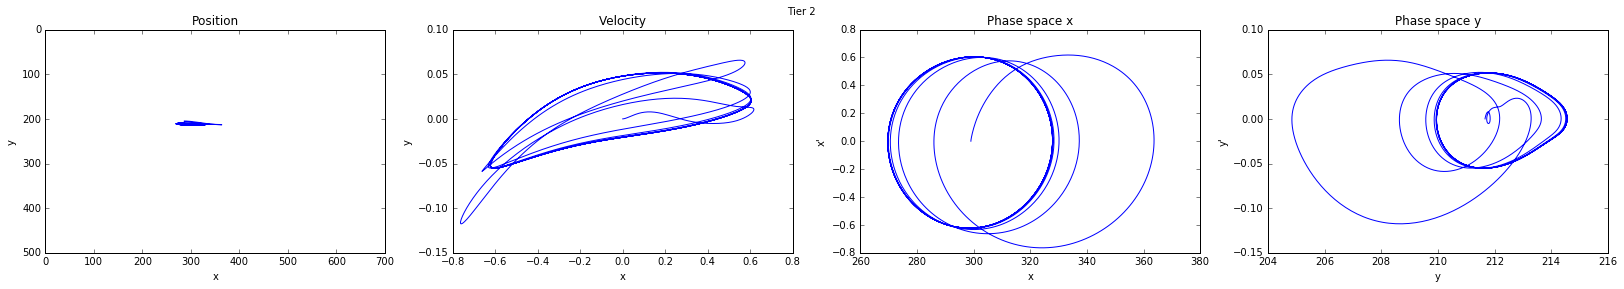

Tier 4


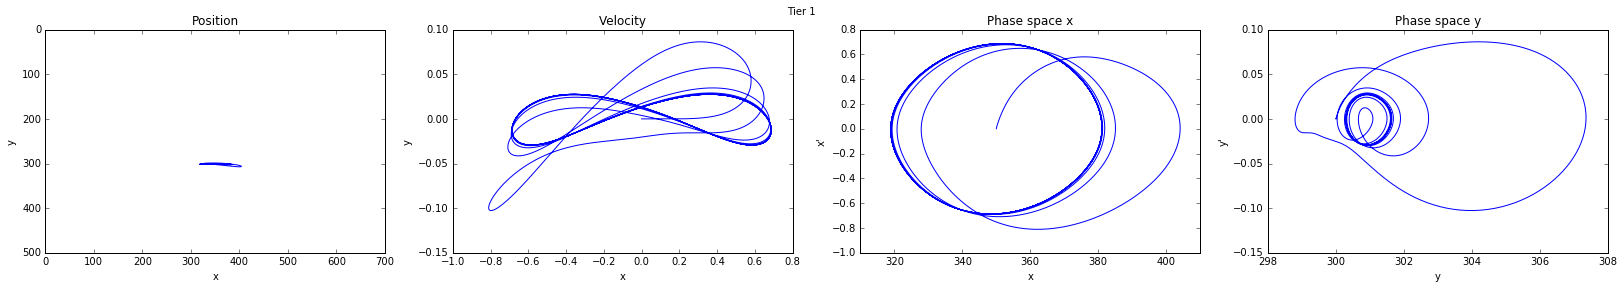

Tier 5


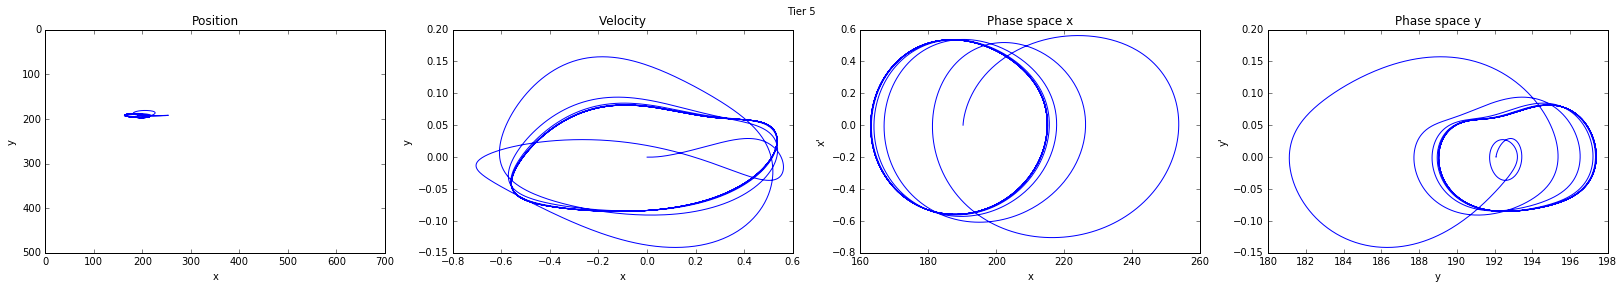

In [12]:
order = [4,3,2,1,5] #the order of the tiers is mixed up because data is collected during recursion
for tier in range(1,ntiers+1):
    print 'Tier ' + str(tier)
    x = tiers[tier]["x"]; v = tiers[tier]["v"];
    plt.figure(figsize=(28,4))
    
    plt.subplot(141) ; plt.title('Position'); plt.xlabel('x'); plt.ylabel('y')
    plt.axis([0.0,cwidth,0.0,cheight])
    plt.gca().invert_yaxis()
    plt.plot(x[:,0], x[:,1],'b-')
    
    plt.subplot(142) ; plt.title('Velocity'); plt.xlabel('x'); plt.ylabel('y')
    plt.plot(v[:,0], v[:,1],'b-')

    plt.subplot(143) ; plt.title('Phase space x'); plt.xlabel('x'); plt.ylabel('x\'')
    plt.plot(x[:,0], v[:,0],'b-')

    plt.subplot(144) ; plt.title('Phase space y'); plt.xlabel('y'); plt.ylabel('y\'')
    plt.plot(x[:,1], v[:,1],'b-')
    
    plt.suptitle('Tier ' + str(order[tier-1]))
    plt.savefig(str(order[tier-1])+'_leftmost_300.png')
    plt.show()

Tier 1


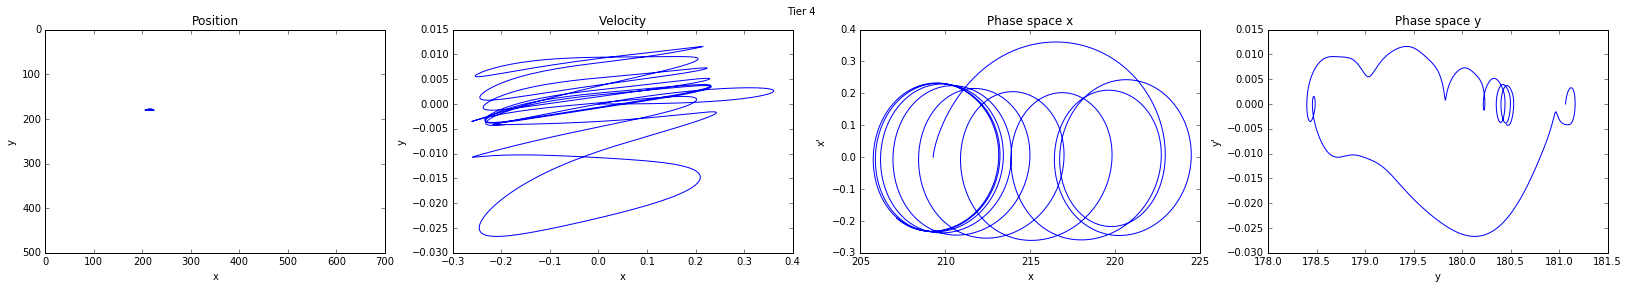

Tier 2


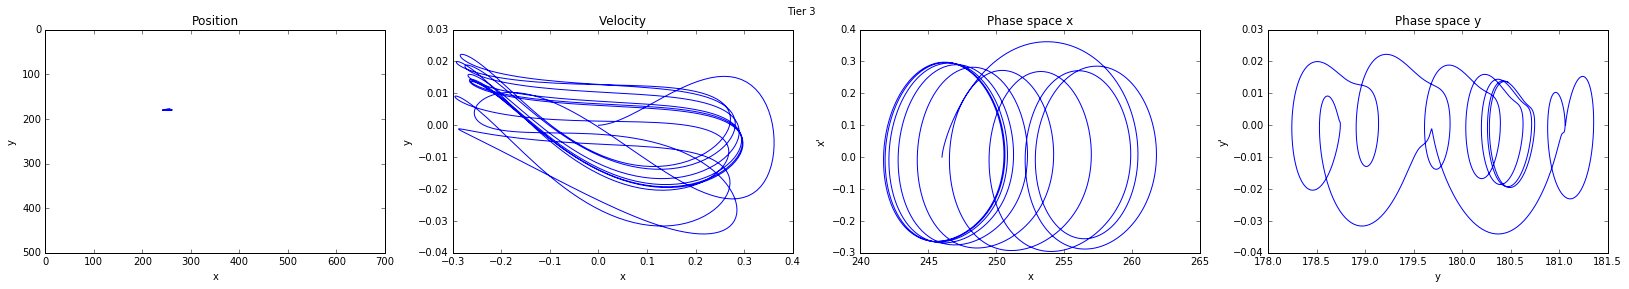

Tier 3


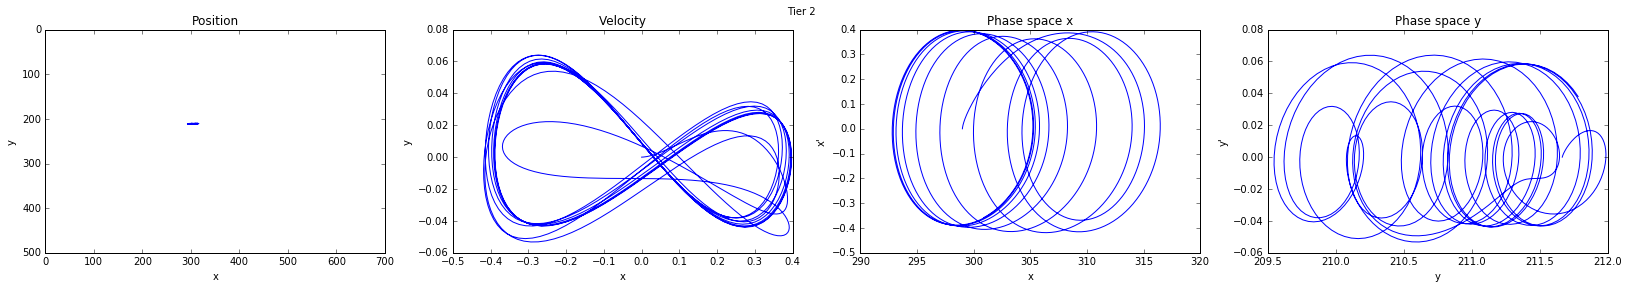

Tier 4


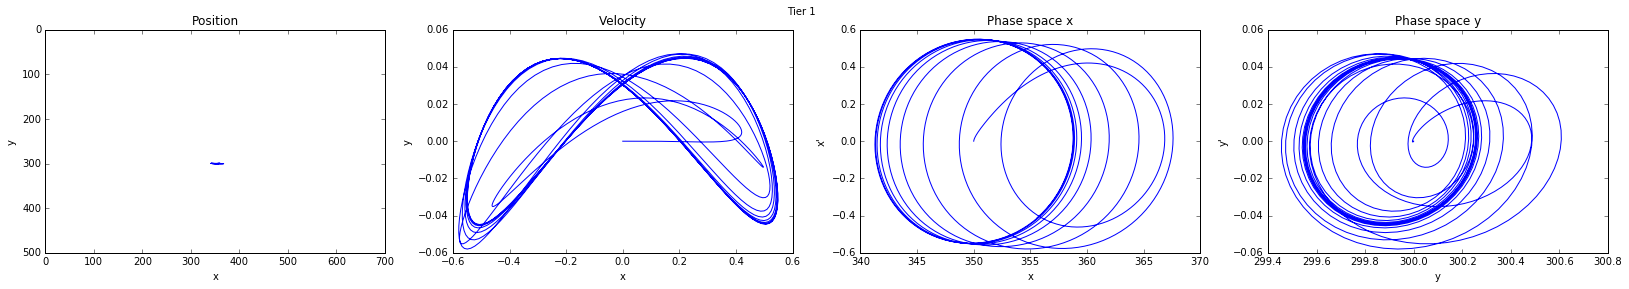

Tier 5


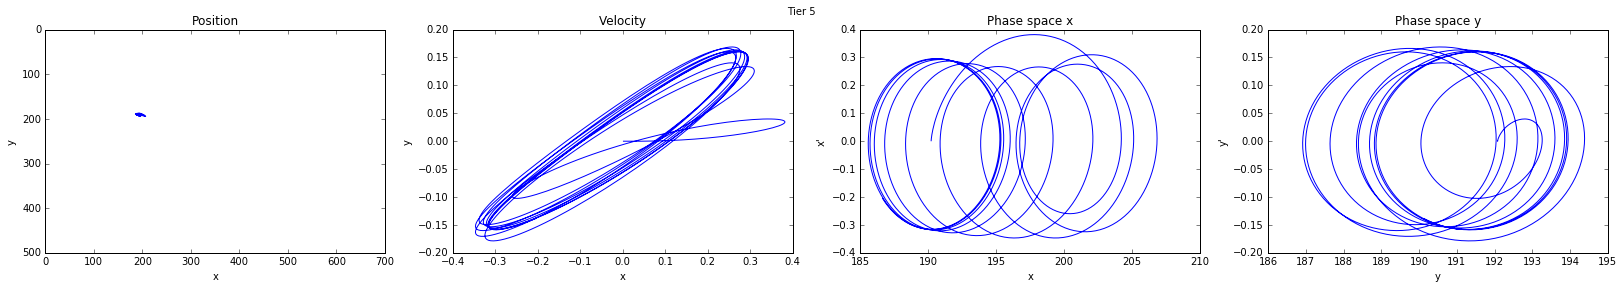

In [13]:
initial_wav = 100
initial_mag = .2
cwidth = 700
cheight = 500
iters = initial_wav*10
ntiers = 5
frac = Fractal(Vec([cwidth, cheight]), 5); force = SinForce(Vec([initial_mag,0]), initial_wav)

node = frac
for tier in range(1,ntiers+1):
    node=node.children[0]
    node.reportData = True
for i in range(iters):
    frac.tick(force.get_force(i))
    
tiers = [{}]
for tier in range(1,ntiers+1):
    tiers.append({});
    tiers[tier]["x"] = frac.data["x"][tier::ntiers]
    tiers[tier]["v"] = frac.data["v"][tier::ntiers]

order = [4,3,2,1,5] #the order of the tiers is mixed up because data is collected during recursion
for tier in range(1,ntiers+1):
    print 'Tier ' + str(tier)
    x = tiers[tier]["x"]; v = tiers[tier]["v"];
    plt.figure(figsize=(28,4))
    
    plt.subplot(141) ; plt.title('Position'); plt.xlabel('x'); plt.ylabel('y')
    plt.axis([0.0,cwidth,0.0,cheight])
    plt.gca().invert_yaxis()
    plt.plot(x[:,0], x[:,1],'b-')
    
    plt.subplot(142) ; plt.title('Velocity'); plt.xlabel('x'); plt.ylabel('y')
    plt.plot(v[:,0], v[:,1],'b-')

    plt.subplot(143) ; plt.title('Phase space x'); plt.xlabel('x'); plt.ylabel('x\'')
    plt.plot(x[:,0], v[:,0],'b-')

    plt.subplot(144) ; plt.title('Phase space y'); plt.xlabel('y'); plt.ylabel('y\'')
    plt.plot(x[:,1], v[:,1],'b-')
    
    plt.suptitle('Tier ' + str(order[tier-1]))
    plt.savefig(str(order[tier-1])+'_leftmost_100.png')
    plt.show()